In [1]:
import torch.utils.data as utils

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

from torch.optim import lr_scheduler

from sklearn.metrics import balanced_accuracy_score

from torch.utils.data import Dataset, DataLoader

import pandas as pd
import pickle

import numpy as np

from barbar import Bar

import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(27)

In [4]:
def plot_acc(history):
    fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
    axarr[0].plot(range(0, len(history)), history['acc'], label='train score')
    axarr[0].plot(range(0, len(history)), history['val_acc'], label='test score')
    axarr[0].set_xlabel('Number of Epochs', fontsize=18)
    axarr[0].set_ylabel('Accuracy', fontsize=18)
    axarr[0].set_ylim([0,1])
    axarr[1].plot(range(0, len(history)), history['acc'], label='train score')
    axarr[1].plot(range(0, len(history)), history['val_acc'], label='test score')
    axarr[1].set_xlabel('Number of Epochs', fontsize=18)
    axarr[1].set_ylabel('Accuracy', fontsize=18)
    axarr[1].set_ylim([0.7,1])
    plt.legend()
    plt.show()

In [5]:
DATAPATH = 'data/features/'
MODELPATH = 'output/models/'

### STEP 2: LOADING DATASET 

In [6]:
class CattleSoundDataset(Dataset):
    """ FreeSound dataset."""

    # Initialize your data, download, etc.
    def __init__(self, X, y):
        
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.len

In [7]:
X_train = np.load('data/train_test/X_train.npy')

In [8]:
X_test = np.load('data/train_test/X_test.npy')

In [9]:
y_train = np.load('data/train_test/y_train.npy')

In [10]:
y_test = np.load('data/train_test/y_test.npy')

In [11]:
print('X_train:', X_train.shape)

print('X_test:', X_test.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (1225, 17640)
X_test: (307, 17640)
y_train: (1225,)
y_test: (307,)


In [12]:
train_dataset = CattleSoundDataset(X_train, y_train)

In [13]:
test_dataset = CattleSoundDataset(X_test, y_test)

### STEP 2: MAKING DATASET ITERABLE

In [14]:
batch_size = 32
n_iters = 2000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [15]:
num_epochs

52

In [16]:
transformations = transforms.Compose([transforms.ToTensor()])

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size= batch_size, 
                                           shuffle=True)

In [18]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [19]:
dataset_sizes = {'train':len(train_loader.dataset),'valid':len(test_loader.dataset)}

In [20]:
dataloaders = {'train':train_loader,'valid':test_loader}

### STEP 3: CREATE MODEL CLASS

In [21]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Conv1d(1, 4, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(4),
            nn.AvgPool1d(2),
            nn.Conv1d(4, 8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.AvgPool1d(2),
            nn.Conv1d(8, 16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.AvgPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1))
        
        self.linear_layers = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes))
                
    def forward(self, x):
        x = x.view(-1, 1, 17640)
        x = self.conv_layers(x)
        x = x.view(-1, 32)
        x = self.linear_layers(x)
        return x

### STEP 4: INSTANTIATE MODEL CLASS

In [22]:
model = CNNModel(num_classes=3)

In [23]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

### STEP 5: INSTANTIATE LOSS CLASS

In [24]:
criterion = nn.CrossEntropyLoss().cuda()

### STEP 6: INSTANTIATE OPTIMIZER CLASS

In [25]:
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### STEP 7: TRAIN THE MODEL

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, graph=False):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0
    
    history = pd.DataFrame()
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Calculate Accuracy         
            y_pred = []
            y_true = []

            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.unsqueeze(1).cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs.unsqueeze(1)), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs.to(dtype=torch.float))
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                
                if torch.cuda.is_available():
                    y_pred += preds.cpu().numpy().tolist()
                    y_true += labels.cpu().numpy().tolist()
                    
                else:
                    y_pred += preds.numpy()
                    y_true += labels.numpy()
        
                

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects / dataset_sizes[phase]
            epoch_acc = balanced_accuracy_score(y_true, y_pred)
            
            if phase == 'train':
                train_acc.append(epoch_acc)
            else:
                val_acc.append(epoch_acc)
            
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    history['val_acc'] = val_acc
    history['acc'] = train_acc
    
    if graph:
        print()
        print('==========' * 10)
        plot_acc(history)
        
        
    
    
    return model, best_epoch

Epoch 0/51
----------
train Loss: 0.0336 Acc: 0.4745
valid Loss: 0.0355 Acc: 0.5365

Epoch 1/51
----------
train Loss: 0.0242 Acc: 0.6080
valid Loss: 0.0240 Acc: 0.6356

Epoch 2/51
----------
train Loss: 0.0212 Acc: 0.6323
valid Loss: 0.0212 Acc: 0.6282

Epoch 3/51
----------
train Loss: 0.0198 Acc: 0.6424
valid Loss: 0.0210 Acc: 0.6299

Epoch 4/51
----------
train Loss: 0.0199 Acc: 0.6481
valid Loss: 0.0200 Acc: 0.7001

Epoch 5/51
----------
train Loss: 0.0186 Acc: 0.6665
valid Loss: 0.0203 Acc: 0.6282

Epoch 6/51
----------
train Loss: 0.0184 Acc: 0.6816
valid Loss: 0.0196 Acc: 0.6547

Epoch 7/51
----------
train Loss: 0.0178 Acc: 0.6994
valid Loss: 0.0196 Acc: 0.6859

Epoch 8/51
----------
train Loss: 0.0178 Acc: 0.6963
valid Loss: 0.0195 Acc: 0.6990

Epoch 9/51
----------
train Loss: 0.0182 Acc: 0.6830
valid Loss: 0.0195 Acc: 0.7083

Epoch 10/51
----------
train Loss: 0.0182 Acc: 0.6859
valid Loss: 0.0197 Acc: 0.7157

Epoch 11/51
----------
train Loss: 0.0179 Acc: 0.6913
valid Loss

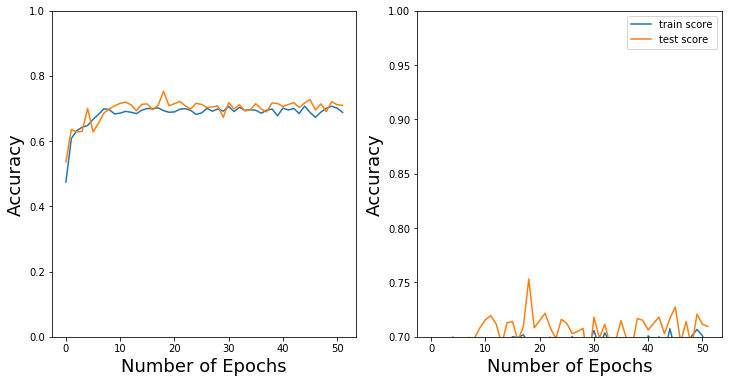

In [27]:
model, best_epoch = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs, graph=True)



### STEP 8: SAVING THE MODEL

In [28]:
state = {
    'epoch': best_epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, MODELPATH+'cnn_pretrained.model')